In [1]:
# 데이터 로드 및 전처리
# reuters 데이터셋을 로드하고, 훈련 데이터셋에서 25%를 검증 데이터셋으로 분리합니다. 
# 이때 파라메터 조정을 통해 단어의 개수는 10000개로 제한합니다(num_words=10000).
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras import models, layers
from tensorflow.keras import callbacks
from tensorflow.keras import utils
from keras.datasets import reuters

In [17]:
# 문제 2-1: reuters 데이터셋을 로드하고, 훈련 데이터셋에서 25%를 검증 데이터셋으로 분리합니다.
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

# 데이터 분할: 훈련 데이터의 25%를 검증 데이터로 분리
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.25)

# 훈련, 검증, 테스트 데이터와 레이블 종류가 몇 개인지 출력합니다.
print(len(train_data))
print(len(val_data))
print(len(test_data))
print(len(set(train_labels)))


6736
2246
2246
46


In [20]:
# 문제 2-2: 텍스트 데이터의 전처리를 위해서 각 데이터셋마다 원-핫 인코딩을 수행합니다.

from tensorflow.keras.utils import to_categorical
def one_hot_encoding(data, dim=10000):
  results = np.zeros((len(data), dim))
  for i, d in enumerate(data):
    results[i, d] = 1.
  return results

x_train = one_hot_encoding(train_data)
x_val = one_hot_encoding(val_data)
x_test = one_hot_encoding(test_data)

# 레이블 데이터들은 범주형 형태로 to_categorical() 함수를 사용해 변환합니다.
num_classes = len(set(train_labels))
y_train = to_categorical(train_labels, num_classes=num_classes)
y_val = to_categorical(val_labels, num_classes=num_classes)
y_test = to_categorical(test_labels, num_classes=num_classes)

In [22]:
# 모델 구성 및 컴파일

# 모델 구성
# 문제 2-3: 빠른 학습과 과대적합을 방지하기 위해 BatchNormalization과 Dropout을 적용한 딥러닝 모델을 구성합니다.
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras.losses import categorical_crossentropy
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

In [25]:
# 문제 2-4: ModelCheckpoint와 EarlyStopping 콜백 함수를 적용하여 모델 학습을 진행합니다.
# ModelCheckpoint와 EarlyStopping 콜백 함수 설정
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

check_point_cb = ModelCheckpoint('best_model.h5', save_best_only=True)
early_stopping_cb = EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)
history = model.fit(x_train, y_train, epochs=60,
                    validation_data=(x_val, y_val),
                    callbacks=[check_point_cb, early_stopping_cb])

Epoch 1/60
211/211 [==============================] - 3s 6ms/step - loss: 2.0009 - accuracy: 0.5727 - val_loss: 1.4918 - val_accuracy: 0.6852
Epoch 2/60
211/211 [==============================] - 1s 5ms/step - loss: 1.1936 - accuracy: 0.7136 - val_loss: 1.1525 - val_accuracy: 0.7351
Epoch 3/60
211/211 [==============================] - 1s 5ms/step - loss: 0.9720 - accuracy: 0.7641 - val_loss: 1.1078 - val_accuracy: 0.7609
Epoch 4/60
211/211 [==============================] - 1s 5ms/step - loss: 0.8061 - accuracy: 0.8061 - val_loss: 1.1007 - val_accuracy: 0.7778
Epoch 5/60
211/211 [==============================] - 1s 5ms/step - loss: 0.7022 - accuracy: 0.8254 - val_loss: 1.0847 - val_accuracy: 0.7930
Epoch 6/60
211/211 [==============================] - 1s 5ms/step - loss: 0.6231 - accuracy: 0.8423 - val_loss: 1.1367 - val_accuracy: 0.7881
Epoch 7/60
211/211 [==============================] - 1s 4ms/step - loss: 0.5644 - accuracy: 0.8541 - val_loss: 1.2210 - val_accuracy: 0.7898
Epoch 

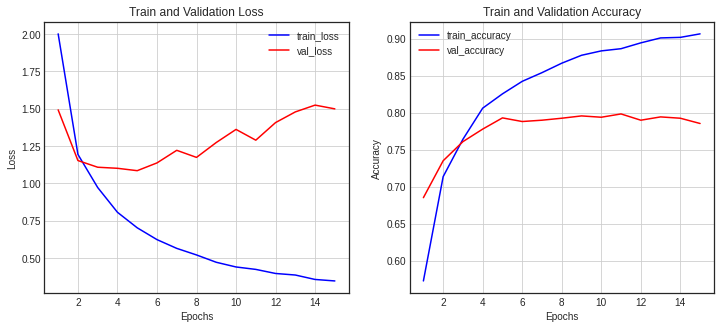

In [26]:
# 학습 히스토리의 `loss`, `val_loss`, `accuracy`, `val_accuracy`를 차트로 시각화합니다.
plt.style.use('seaborn-white')

history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, 'b-', label='train_loss')
ax1.plot(epochs, val_loss, 'r-', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, accuracy, 'b-', label='train_accuracy')
ax2.plot(epochs, val_accuracy, 'r-', label='val_accuracy')
ax2.set_title('Train and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.show()

In [27]:
# 문제 2-5: 테스트 데이터셋을 이용해 모델을 평가합니다.
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print("테스트 손실:", test_loss)
print("테스트 정확도:", test_accuracy)

71/71 [==============================] - 0s 2ms/step - loss: 1.1924 - accuracy: 0.7676
테스트 손실: 1.192432165145874
테스트 정확도: 0.7675868272781372
